# Greenspace metrics at multiple spatial scales from satellite images

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import rasterio
import os
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import time
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
from rasterio.transform import from_origin
from rasterio.plot import show
from shapely.geometry import box, Point, Polygon
from osgeo import gdal
from geopandas import GeoSeries
from geopandas.tools import sjoin
from numpy.random import RandomState
from skimage.filters.rank import modal
from skimage.util import img_as_ubyte

%matplotlib inline

In [2]:
#!pip install scikit-learn
#!pip install -U scikit-image

# 1. NDVI

## 1.1. NDVI input map

In [3]:
# data dir
data_dir = r"thesis_project/data"
fp = os.path.join(data_dir, "CR_NDVI.TIF")

# open the file
ndvi_input_raster = rasterio.open(fp)

# check type of the variable 'raster'
type(ndvi_input_raster)

rasterio.io.DatasetReader

In [4]:
# check metadata for the whole raster dataset
ndvi_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.3999999521443642e+38,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

In [5]:
ndvi_input_raster.bounds

BoundingBox(left=341660.6724, bottom=371164.6389, right=416090.6724, top=431034.6389)

In [6]:
# read the raster band as separate variable
ndvi_input = ndvi_input_raster.read(1)
type(ndvi_input)

numpy.ndarray

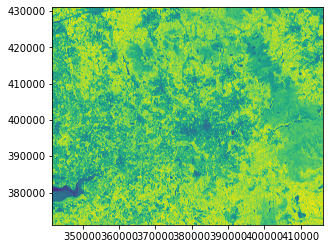

<AxesSubplot:>

In [7]:
# plot input NDVI
show(ndvi_input_raster, 1)

## 1.2. Focal statistics

### 1.2.1. Focal statistics at 100m

In [8]:
# design kernel at a 100m scale
ndvi_filter_100 = np.ones((21, 21))
ndvi_filter_100.shape

(21, 21)

In [9]:
# FFT convolve NDVI input with kernel at 100m (equivalent to average operation)
start_time = time.time()
ndvi_output_100 = fftconvolve(ndvi_input, ndvi_filter_100, mode = "same") / np.sum(ndvi_filter_100) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_100.shape

--- 2.605879783630371 seconds ---


(5987, 7443)

### 1.2.2. Focal statistics at 300m

In [10]:
# design kernel at a 300m scale
ndvi_filter_300 = np.ones((61, 61))
ndvi_filter_300.shape

(61, 61)

In [11]:
# FFT convolve NDVI input with kernel at 300m (equivalent to average operation)
start_time = time.time()
ndvi_output_300 = fftconvolve(ndvi_input, ndvi_filter_300, mode = "same") / np.sum(ndvi_filter_300) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_300.shape

--- 2.6984221935272217 seconds ---


(5987, 7443)

### 1.2.3. Focal statistics at 500m

In [12]:
# design kernel at a 500m scale
ndvi_filter_500 = np.ones((101, 101))
ndvi_filter_500.shape

(101, 101)

In [13]:
# FFT convolve NDVI input with kernel at 500m (equivalent to average operation)
start_time = time.time()
ndvi_output_500 = fftconvolve(ndvi_input, ndvi_filter_500, mode = "same") / np.sum(ndvi_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_500.shape

--- 2.655224084854126 seconds ---


(5987, 7443)

## 1.3. NDVI output layer

### 1.3.1. NDVI output layer at 100m

In [14]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_100.tif', 'w', driver='GTiff',
                            height = ndvi_output_100.shape[0], width = ndvi_output_100.shape[1],
                            count=1, dtype=str(ndvi_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_100, 1)
new_dataset.close()

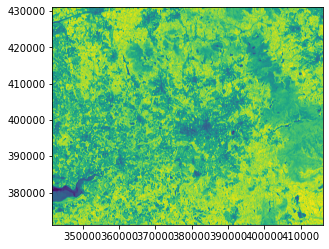

--- 2.0770199298858643 seconds ---


In [15]:
# NDVI layer output at 100m
start_time = time.time()
ndvi_src_100 = rasterio.open("thesis_project/output/layers/ndvi_output_100.tif")
show(ndvi_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
# output layer metadata
ndvi_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.2. NDVI output layer at 300m

In [17]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_300.tif', 'w', driver='GTiff',
                            height = ndvi_output_300.shape[0], width = ndvi_output_300.shape[1],
                            count=1, dtype=str(ndvi_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_300, 1)
new_dataset.close()

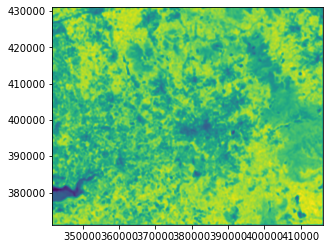

--- 2.113279104232788 seconds ---


In [18]:
# NDVI layer output at 300m
start_time = time.time()
ndvi_src_300 = rasterio.open("thesis_project/output/layers/ndvi_output_300.tif")
show(ndvi_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
# check meta
ndvi_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.3. NDVI output layer at 500m

In [20]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_500.tif', 'w', driver='GTiff',
                            height = ndvi_output_500.shape[0], width = ndvi_output_500.shape[1],
                            count=1, dtype=str(ndvi_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_500, 1)
new_dataset.close()

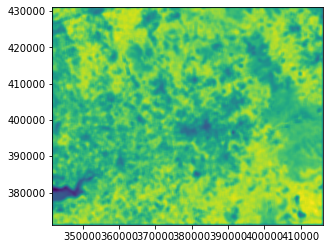

--- 2.097353935241699 seconds ---


In [21]:
# NDVI layer output at 500m
start_time = time.time()
ndvi_src_500 = rasterio.open("thesis_project/output/layers/ndvi_output_500.tif")
show(ndvi_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
# check crs
ndvi_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

## 1.4. Generate random points within Greater Manchester Area

In [23]:
# Greater Manchester Area bounds
gm_boundaries = gpd.read_file("thesis_project/data/GM_Boundary.gpkg")
gm_boundaries.bounds

,minx,miny,maxx,maxy
0,351662.603729,381165.401794,406087.19669,421037.698468


### 1.4.1. Generate random points at 100m from each other

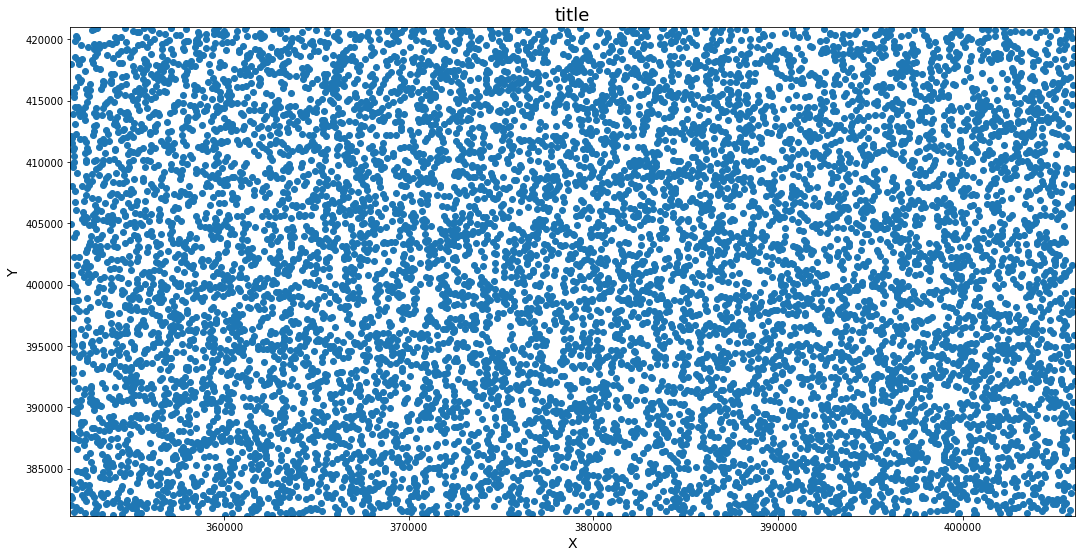

In [24]:
# generate random points at 100m from each other
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

#prng = RandomState(1234567890)

points_100 = np.array([])       # x, y columnwise
while points_100.shape[0] < 10000:
    np.random.seed(42)
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_100) == 0:                # add first point blindly
        points_100 = np.array([p])
    elif distance(p, points_100, 100):     # ensure the minimum distance is met
        points_100 = np.vstack((points_100, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_100[:,0], points_100[:,1])

In [25]:
# convert np array to point geometry
x, y = np.split(points_100,[-1],axis=1) # split array into x and y
sample_100 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_100 = pd.DataFrame(sample_100, columns=['geometry'])
gdf_100 = gpd.GeoDataFrame(df_100, geometry='geometry', crs = 'epsg:27700')
gdf_100.head()                      


,geometry
0,POINT (400173.361 405813.506)
1,POINT (372621.724 413362.205)
2,POINT (400871.636 383945.725)
3,POINT (360836.505 417442.776)
4,POINT (383564.442 390537.080)


In [26]:
# save gpd to GeoJSON
gdf_100.to_file("thesis_project/output/points/sample_points_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.2. Generate random points at 300m from each other

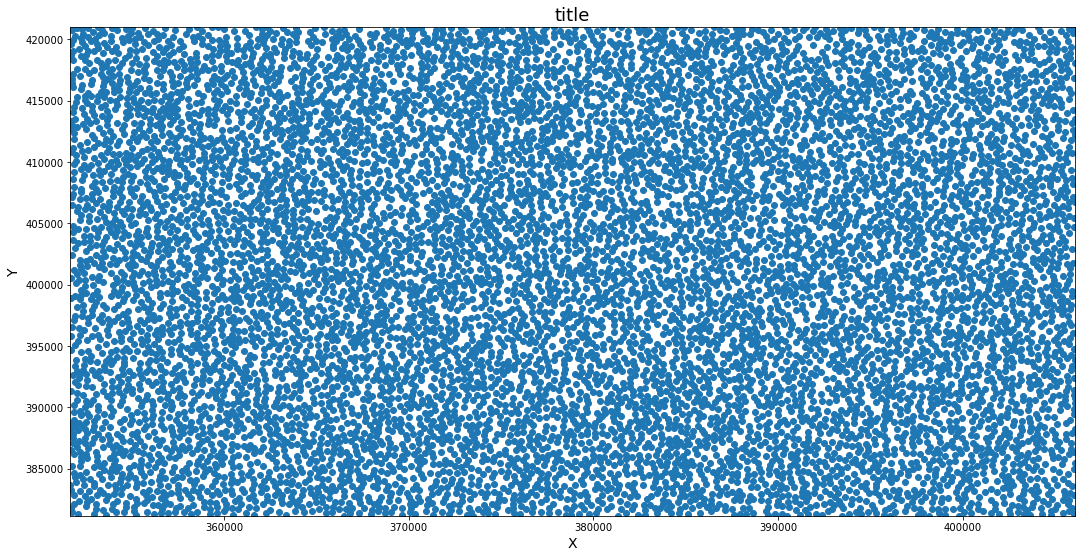

In [27]:
# generate random points at 300m from each other
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_300 = np.array([])       # x, y columnwise
while points_300.shape[0] < 10000:
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_300) == 0:                # add first point blindly
        points_300 = np.array([p])
    elif distance(p, points_300, 300):     # ensure the minimum distance is met
        points_300 = np.vstack((points_300, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_300[:,0], points_300[:,1])

In [28]:
# convert np array to point geometry
x, y = np.split(points_300,[-1],axis=1) # split array into x and y
sample_300 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_300 = pd.DataFrame(sample_300, columns=['geometry'])
gdf_300 = gpd.GeoDataFrame(df_300, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_300.to_file("thesis_project/output/points/sample_points_300.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.3. Generate random points at 500m from each other

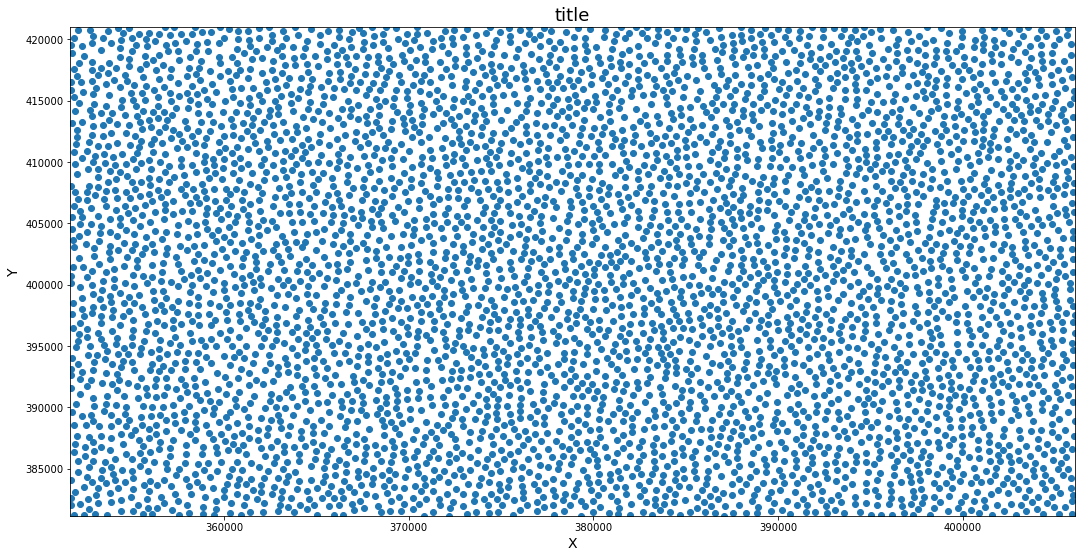

In [29]:
# generate random points at 500m from each other
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_500 = np.array([])       # x, y columnwise
while points_500.shape[0] < 5000:
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_500) == 0:                # add first point blindly
        points_500 = np.array([p])
    elif distance(p, points_500, 500):     # ensure the minimum distance is met
        points_500 = np.vstack((points_500, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_500[:,0], points_500[:,1])

In [30]:
# convert np array to point geometry
x, y = np.split(points_500,[-1],axis=1) # split array into x and y
points_500 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_500 = pd.DataFrame(points_500, columns=['geometry'])
gdf_500 = gpd.GeoDataFrame(df_500, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_500.to_file("thesis_project/output/points/sample_points_500.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# 1.5. Extract raster values at point locations and store them into a Geodataframe

### 1.5.1. NDVI values at 100m

In [31]:
# check point locations df
gdf_100.head()

,geometry
0,POINT (400173.361 405813.506)
1,POINT (372621.724 413362.205)
2,POINT (400871.636 383945.725)
3,POINT (360836.505 417442.776)
4,POINT (383564.442 390537.080)


In [32]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_100['point_coordinates'] = point_coords
gdf_100.head()

,geometry,point_coordinates
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)"
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)"
2,POINT (400871.636 383945.725),"(400871.6357909384, 383945.7248443085)"
3,POINT (360836.505 417442.776),"(360836.5048575175, 417442.77625065)"
4,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)"


In [33]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['NDVI_100'] = [x[0] for x in ndvi_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596
2,POINT (400871.636 383945.725),"(400871.6357909384, 383945.7248443085)",0.496076
3,POINT (360836.505 417442.776),"(360836.5048575175, 417442.77625065)",0.623076
4,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539


### 1.5.2. NDVI values at 300m

In [34]:
# check point locations df
gdf_300.head()

,geometry
0,POINT (382286.540 396971.736)
1,POINT (401663.522 389314.982)
2,POINT (357290.163 414624.574)
3,POINT (380292.947 385966.872)
4,POINT (388038.733 412187.156)


In [35]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_300['point_coordinates'] = point_coords
gdf_300.head()

,geometry,point_coordinates
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)"
1,POINT (401663.522 389314.982),"(401663.52153737843, 389314.982007001)"
2,POINT (357290.163 414624.574),"(357290.1629167593, 414624.5741397106)"
3,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)"
4,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)"


In [36]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['NDVI_300'] = [x[0] for x in ndvi_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958
1,POINT (401663.522 389314.982),"(401663.52153737843, 389314.982007001)",0.667160
2,POINT (357290.163 414624.574),"(357290.1629167593, 414624.5741397106)",0.654879
3,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179
4,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117


### 1.5.3. NDVI values at 500m

In [37]:
# check point locations df
gdf_500.head()

,geometry
0,POINT (362886.156 402352.157)
1,POINT (354204.802 403929.521)
2,POINT (388852.933 417898.122)
3,POINT (379393.300 410476.219)
4,POINT (365634.081 416583.121)


In [38]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_500['point_coordinates'] = point_coords
gdf_500.head()

,geometry,point_coordinates
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)"
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)"
2,POINT (388852.933 417898.122),"(388852.93274033023, 417898.1224321289)"
3,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)"
4,POINT (365634.081 416583.121),"(365634.0807027881, 416583.1209378054)"


In [39]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['NDVI_500'] = [x[0] for x in ndvi_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380
2,POINT (388852.933 417898.122),"(388852.93274033023, 417898.1224321289)",0.518479
3,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857
4,POINT (365634.081 416583.121),"(365634.0807027881, 416583.1209378054)",0.357754


# 2. Greenspace%

## 2.1. Green No Green input map

In [40]:
# data dir
data_dir = r"thesis_project/data"
fp_green = os.path.join(data_dir, "GreenNoGreenRes.TIF")

# open the file
green_input_raster = rasterio.open(fp_green)

# check type of the variable 'raster'
type(green_input_raster)

rasterio.io.DatasetReader

In [41]:
# check metadata for the whole raster dataset
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

In [42]:
# read the raster band as separate variable
green_input = green_input_raster.read(1)
#type(green_input)
green_input

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

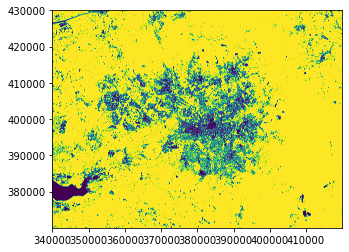

<AxesSubplot:>

In [43]:
# plot input % Greenness
show(green_input_raster, 1)

## 2.2. Focal statistics

### 2.2.1. Focal statistics at 100m

In [44]:
# design kernel at a 100m scale
green_filter_100 = np.ones((41, 41))
green_filter_100.shape

(41, 41)

In [45]:
# FFT convolve Green No Green input with kernel at 100m (r = 41)
start_time = time.time()
green_output_100 = fftconvolve(green_input, green_filter_100, mode = "same") / np.sum(green_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_100.shape

--- 21.85686421394348 seconds ---


(12000, 16000)

### 2.2.2. Focal statistics at 300m

In [46]:
# design kernel at a 300m scale
green_filter_300 = np.ones((121, 121))
green_filter_300.shape

(121, 121)

In [47]:
# FFT convolve Green No Green input with kernel at 300m (r = 121)
start_time = time.time()
green_output_300 = fftconvolve(green_input, green_filter_300, mode = "same") / np.sum(green_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_300.shape

--- 22.07598090171814 seconds ---


(12000, 16000)

### 2.2.3. Focal statistics at 500m

In [48]:
# design kernel at a 500m scale
green_filter_500 = np.ones((201, 201))
green_filter_500.shape

(201, 201)

In [49]:
# FFT convolve Green No Green input with kernel at 500m (r = 201)
start_time = time.time()
green_output_500 = fftconvolve(green_input, green_filter_500, mode = "same") / np.sum(green_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_500.shape

--- 21.72574210166931 seconds ---


(12000, 16000)

## 2.3. Greenspace% output layer

In [50]:
# Green NO Green input map bounds
green_input_raster.bounds

BoundingBox(left=339999.2458, bottom=370003.9122, right=419999.2458, top=430003.9122)

In [51]:
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.1. Greenspace% output layer at 100m

In [52]:
# convert Greenspace% output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_100.tif', 'w', driver='GTiff',
                            height = green_output_100.shape[0], width = green_output_100.shape[1],
                            count=1, dtype=str(green_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_100, 1)
new_dataset.close()

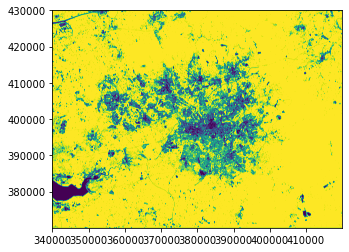

--- 14.566994905471802 seconds ---


In [53]:
# % greenness layer output at 100m
start_time = time.time()
green_src_100 = rasterio.open("thesis_project/output/layers/green_output_100.tif")
show(green_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [54]:
# output layer metadata
green_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.2. Greenspace% output layer at 300m

In [55]:
# convert Greenspace% output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_300.tif', 'w', driver='GTiff',
                            height = green_output_300.shape[0], width = green_output_300.shape[1],
                            count=1, dtype=str(green_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_300, 1)
new_dataset.close()

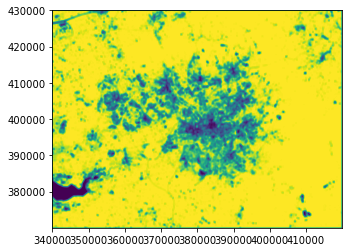

--- 12.525693893432617 seconds ---


In [56]:
# Greenspace% layer output at 300m
start_time = time.time()
green_src_300 = rasterio.open("thesis_project/output/layers/green_output_300.tif")
show(green_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [57]:
# output layer metadata
green_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.3. Greenspace% output layer at 500m

In [58]:
# convert Greenspace% output to raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_500.tif', 'w', driver='GTiff',
                            height = green_output_500.shape[0], width = green_output_500.shape[1],
                            count=1, dtype=str(green_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_500, 1)
new_dataset.close()

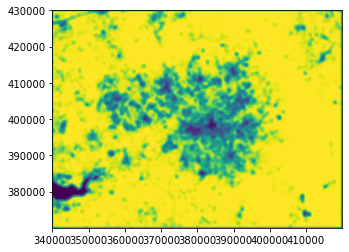

--- 14.900630950927734 seconds ---


In [59]:
# Greenspace% layer output at 500m
start_time = time.time()
green_src_500 = rasterio.open("thesis_project/output/layers/green_output_500.tif")
show(green_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [60]:
# output layer metadata
green_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

## 2.4. Extract raster values at point locations and store them into a Geodataframe

### 2.4.1. Greenspace% values at 100m

In [61]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Greenspace%_100'] = [x[0] for x in green_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057,0.780488
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596,0.665080
2,POINT (400871.636 383945.725),"(400871.6357909384, 383945.7248443085)",0.496076,0.885782
3,POINT (360836.505 417442.776),"(360836.5048575175, 417442.77625065)",0.623076,1.000000
4,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539,1.000000


In [62]:
# check if null values in gdf
gdf_100.isnull().values.any()

False

### 2.4.2. Greenspace% values at 300m

In [63]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Greenspace%_300'] = [x[0] for x in green_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958,0.355645
1,POINT (401663.522 389314.982),"(401663.52153737843, 389314.982007001)",0.667160,0.999727
2,POINT (357290.163 414624.574),"(357290.1629167593, 414624.5741397106)",0.654879,0.978963
3,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179,0.962298
4,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117,0.759169


In [64]:
# check if null values in gdf
gdf_300.isnull().values.any()

False

### 2.4.3. Greenspace% values at 500m

In [65]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Greenspace%_500'] = [x[0] for x in green_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912,0.888815
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380,0.877726
2,POINT (388852.933 417898.122),"(388852.93274033023, 417898.1224321289)",0.518479,0.966436
3,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857,0.457192
4,POINT (365634.081 416583.121),"(365634.0807027881, 416583.1209378054)",0.357754,1.000000


In [66]:
# check if null values in gdf
gdf_500.isnull().values.any()

False

# 3. Canopy%

## 3.1. Tree No Trees input map

In [67]:
# data dir
data_dir = r"thesis_project/data"
fp_tree = os.path.join(data_dir, "Tree_no_trees_2m.TIF")

# open the file
tree_input_raster = rasterio.open(fp_tree)

# check type of the variable 'raster'
type(tree_input_raster)

rasterio.io.DatasetReader

In [68]:
# check metadata for the whole raster dataset
tree_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 26119,
 'height': 19520,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(2.0, 0.0, 351667.1259,
        0.0, -2.0, 420207.084)}

In [69]:
# read the raster band as separate variable
tree_input = tree_input_raster.read(1)
#tree_input
type(tree_input)


numpy.ndarray

In [70]:
# convert array to uint8
tree_input = tree_input.astype(np.uint8)
tree_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

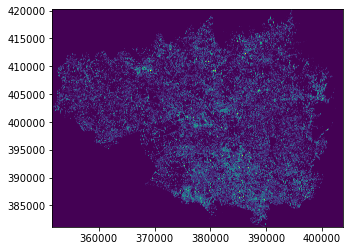

<AxesSubplot:>

In [71]:
# plot Tree No Trees input map
show(tree_input_raster, 1)

## 3.2. Focal statistics

### 3.2.1. Focal statistics at 100m

In [72]:
# design kernel at a 100m scale
canopy_filter_100 = np.ones((101, 101))
canopy_filter_100.shape

(101, 101)

In [73]:
# FFT convolve Tree No Trees input with kernel at 100m (r = 101)
start_time = time.time()
canopy_output_100 = fftconvolve(tree_input, canopy_filter_100, mode = "same") / np.sum(canopy_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_100.shape

--- 263.85241508483887 seconds ---


(19520, 26119)

### 3.2.2. Focal statistics at 300m

In [74]:
# design kernel at a 300m scale
canopy_filter_300 = np.ones((301, 301))
canopy_filter_300.shape

(301, 301)

In [75]:
# FFT convolve Tree No Trees input with kernel at 300m (r = 301)
start_time = time.time()
canopy_output_300 = fftconvolve(tree_input, canopy_filter_300, mode = "same") / np.sum(canopy_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_300.shape

--- 378.80484986305237 seconds ---


(19520, 26119)

### 3.2.3. Focal statistics at 500m

In [76]:
# design kernel at a 500m scale
canopy_filter_500 = np.ones((501, 501))
canopy_filter_500.shape

(501, 501)

In [77]:
# FFT convolve Tree No Trees input with kernel at 500m (r = 501)
start_time = time.time()
canopy_output_500 = fftconvolve(tree_input, canopy_filter_500, mode = "same") / np.sum(canopy_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_500.shape

--- 355.57757902145386 seconds ---


(19520, 26119)

## 3.3. Canopy% output layer

In [78]:
# checking bounds
tree_input_raster.bounds

BoundingBox(left=351667.1259, bottom=381167.084, right=403905.1259, top=420207.084)

### 3.3.1. Canopy% output layer at 100m

In [80]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_100.tif', 'w', driver='GTiff',
                            height = canopy_output_100.shape[0], width = canopy_output_100.shape[1],
                            count=1, dtype=str(canopy_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_100, 1)
new_dataset.close()

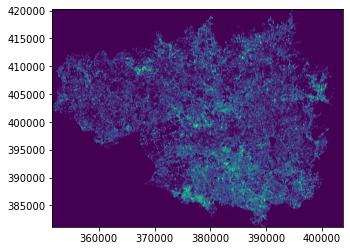

--- 54.87402296066284 seconds ---


In [81]:
# Tree no Trees output layer at 100m
start_time = time.time()
canopy_src_100 = rasterio.open("thesis_project/output/layers/canopy_output_100.tif")
show(canopy_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [82]:
# output layer metadata
canopy_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 26119,
 'height': 19520,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(2.0, 0.0, 351667.1259,
        0.0, -2.0, 420207.084)}

### 3.3.2. Canopy% output layer at 300m

In [83]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_300.tif', 'w', driver='GTiff',
                            height = canopy_output_300.shape[0], width = canopy_output_300.shape[1],
                            count=1, dtype=str(canopy_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_300, 1)
new_dataset.close()

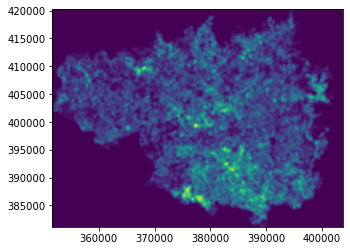

--- 66.06021499633789 seconds ---


In [84]:
# Tree no Trees output layer at 300m
start_time = time.time()
canopy_src_300 = rasterio.open("thesis_project/output/layers/canopy_output_300.tif")
show(canopy_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

### 3.3.3. Canopy% output layer at 500m

In [85]:
# convert Tree no Trees output to raster image
transform = from_origin(351667.1259, 420207.084, 2.0, 2.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_500.tif', 'w', driver='GTiff',
                            height = canopy_output_500.shape[0], width = canopy_output_500.shape[1],
                            count=1, dtype=str(canopy_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_500, 1)
new_dataset.close()

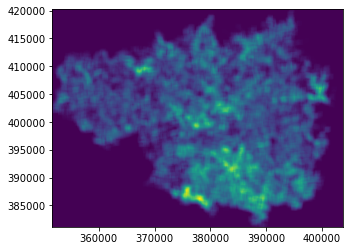

--- 57.569047689437866 seconds ---


In [86]:
# Tree no Trees output layer at 500m
start_time = time.time()
canopy_src_500 = rasterio.open("thesis_project/output/layers/canopy_output_500.tif")
show(canopy_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

## 3.4. Extract raster values at point locations within Greater Manchester Area and store them into a Geodataframe

In [87]:
# read Geopackage containing GM boundary
gm_boundaries = gpd.read_file("thesis_project/data/GM_Boundary.gpkg")
gm_boundaries.head()

,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,geometry
0,1,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,"MULTIPOLYGON (((406087.197 404640.102, 406041...."


<AxesSubplot:>

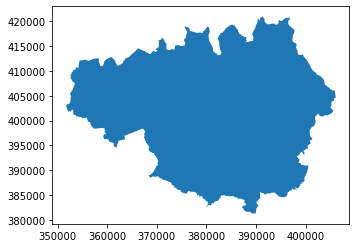

In [88]:
# plot GM boundary
gm_boundaries.plot()

### 3.4.1. Canopy% values at 100m

In [89]:
# check gdf
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057,0.780488
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596,0.665080
2,POINT (400871.636 383945.725),"(400871.6357909384, 383945.7248443085)",0.496076,0.885782
3,POINT (360836.505 417442.776),"(360836.5048575175, 417442.77625065)",0.623076,1.000000
4,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539,1.000000


In [90]:
# join greenspace metrics and GM boundaries
gdf_100_full = sjoin(gdf_100, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_100 = gdf_100_full[gdf_100_full['index_right'].notna()].reset_index(drop=True)
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057,0.780488,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596,0.665080,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539,1.000000,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (390233.154 383013.102),"(390233.154220036, 383013.10249888024)",0.623242,0.916716,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (391596.504 398918.321),"(391596.50390720594, 398918.3206943208)",0.295044,0.403331,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [91]:
# check how many points within GM with all metrics
len(gdf_100)

5836

In [92]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Canopy%_100'] = [x[0] for x in canopy_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057,0.780488,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.375649
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596,0.665080,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.100480
2,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539,1.000000,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.203607
3,POINT (390233.154 383013.102),"(390233.154220036, 383013.10249888024)",0.623242,0.916716,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.120871
4,POINT (391596.504 398918.321),"(391596.50390720594, 398918.3206943208)",0.295044,0.403331,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.075581


## 3.4.2. Canopy% values at 300m

In [93]:
# check gdf
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958,0.355645
1,POINT (401663.522 389314.982),"(401663.52153737843, 389314.982007001)",0.667160,0.999727
2,POINT (357290.163 414624.574),"(357290.1629167593, 414624.5741397106)",0.654879,0.978963
3,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179,0.962298
4,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117,0.759169


In [94]:
# join greenspace metrics and GM boundaries
gdf_300_full = sjoin(gdf_300, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_300 = gdf_300_full[gdf_300_full['index_right'].notna()].reset_index(drop=True)
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958,0.355645,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179,0.962298,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117,0.759169,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (376338.417 418312.798),"(376338.41668971744, 418312.7984642988)",0.431354,0.994809,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (400702.374 407703.870),"(400702.3736142079, 407703.87039896694)",0.602636,0.887576,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [95]:
# check how many points within GM with all metrics
len(gdf_300)

5861

In [96]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Canopy%_300'] = [x[0] for x in canopy_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958,0.355645,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,7.594839e-02
1,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179,0.962298,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.193055e-02
2,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117,0.759169,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.804528e-02
3,POINT (376338.417 418312.798),"(376338.41668971744, 418312.7984642988)",0.431354,0.994809,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.046113e-17
4,POINT (400702.374 407703.870),"(400702.3736142079, 407703.87039896694)",0.602636,0.887576,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.580468e-02


### 3.4.3. Canopy% values at 500m

In [97]:
# check gdf
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912,0.888815
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380,0.877726
2,POINT (388852.933 417898.122),"(388852.93274033023, 417898.1224321289)",0.518479,0.966436
3,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857,0.457192
4,POINT (365634.081 416583.121),"(365634.0807027881, 416583.1209378054)",0.357754,1.000000


In [98]:
# join greenspace metrics and GM boundaries
gdf_500_full = sjoin(gdf_500, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_500 = gdf_500_full[gdf_500_full['index_right'].notna()].reset_index(drop=True)
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912,0.888815,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380,0.877726,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857,0.457192,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (385552.048 388856.047),"(385552.0481683999, 388856.047282936)",0.460191,0.652385,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (367806.732 411583.484),"(367806.732180306, 411583.4836614798)",0.641393,0.992871,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [99]:
# check how many points within GM with all metrics
len(gdf_500)

2907

In [100]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Canopy%_500'] = [x[0] for x in canopy_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912,0.888815,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.079314
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380,0.877726,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104434
2,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857,0.457192,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.147824
3,POINT (385552.048 388856.047),"(385552.0481683999, 388856.047282936)",0.460191,0.652385,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.214477
4,POINT (367806.732 411583.484),"(367806.732180306, 411583.4836614798)",0.641393,0.992871,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.034099


# 4. Grass%

## 4.1. Grass No Grass input map

In [101]:
# data dir
data_dir = r"thesis_project/data"
fp_grass = os.path.join(data_dir, "Grass_no_grass_10m.TIF")

# open the file
grass_input_raster = rasterio.open(fp_grass)

# check type of the variable 'raster'
type(grass_input_raster)

rasterio.io.DatasetReader

In [102]:
# check metadata for the whole raster dataset
grass_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

In [103]:
# read the raster band as separate variable
grass_input = grass_input_raster.read(1)
#grass_input
type(grass_input)

numpy.ndarray

In [104]:
# convert array to uint8
grass_input = grass_input.astype(np.uint8)
grass_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

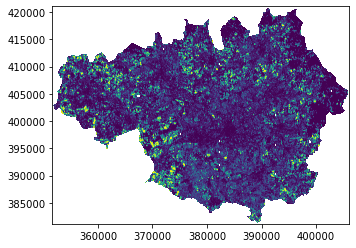

<AxesSubplot:>

In [105]:
# plot input map
show(grass_input_raster, 1)

## 4.2. Focal statistics

### 4.2.1. Focal statistics at 100m

In [106]:
# design kernel at a 100m scale
grass_filter_100 = np.ones((21, 21))
grass_filter_100.shape

(21, 21)

In [107]:
# FFT convolve input map with kernel at 100m (equivalent to average operation)
start_time = time.time()
grass_output_100 = fftconvolve(grass_input, grass_filter_100, mode = "same") / np.sum(grass_filter_100) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_100.shape

--- 1.700324296951294 seconds ---


(3987, 5441)

### 4.2.2. Focal statistics at 300m

In [108]:
# design kernel at a 300m scale
grass_filter_300 = np.ones((61, 61))
grass_filter_300.shape

(61, 61)

In [109]:
# FFT convolve input map with kernel at 300m (equivalent to average operation)
start_time = time.time()
grass_output_300 = fftconvolve(grass_input, grass_filter_300, mode = "same") / np.sum(grass_filter_300) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_300.shape

--- 2.5118868350982666 seconds ---


(3987, 5441)

### 4.2.3. Focal statistics at 500m

In [110]:
# design kernel at a 500m scale
grass_filter_500 = np.ones((101, 101))
grass_filter_500.shape

(101, 101)

In [111]:
# FFT convolve input map with kernel at 500m (equivalent to average operation)
start_time = time.time()
grass_output_500 = fftconvolve(grass_input, grass_filter_500, mode = "same") / np.sum(grass_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_500.shape

--- 2.4350759983062744 seconds ---


(3987, 5441)

## 4.3. Grass% output layer

In [112]:
# checking bounds
grass_input_raster.bounds

BoundingBox(left=351662.35, bottom=381166.0433, right=406072.35, top=421036.0433)

### 4.3.1. Grass% output layer at 100m

In [113]:
# convert Grass% output to raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_100.tif', 'w', driver='GTiff',
                            height = grass_output_100.shape[0], width = grass_output_100.shape[1],
                            count=1, dtype=str(grass_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_100, 1)
new_dataset.close()

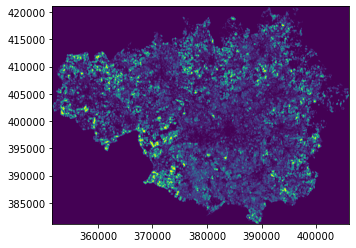

--- 2.616508960723877 seconds ---


In [114]:
# Grass% layer output at 100m
start_time = time.time()
grass_src_100 = rasterio.open("thesis_project/output/layers/grass_output_100.tif")
show(grass_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [115]:
# output layer metadata
grass_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 4.3.2. Grass% output layer at 300m

In [116]:
# convert Grass% output to raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_300.tif', 'w', driver='GTiff',
                            height = grass_output_300.shape[0], width = grass_output_300.shape[1],
                            count=1, dtype=str(grass_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_300, 1)
new_dataset.close()

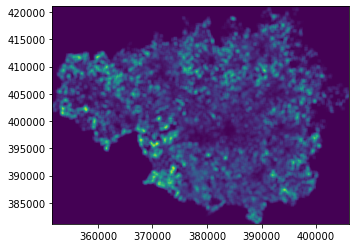

--- 1.9373853206634521 seconds ---


In [117]:
# Grass% layer output at 300m
start_time = time.time()
grass_src_300 = rasterio.open("thesis_project/output/layers/grass_output_300.tif")
show(grass_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [118]:
# output layer metadata
grass_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 4.3.3. Grass% output layer at 500m

In [119]:
# convert Grass% output to raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_500.tif', 'w', driver='GTiff',
                            height = grass_output_500.shape[0], width = grass_output_500.shape[1],
                            count=1, dtype=str(grass_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_500, 1)
new_dataset.close()

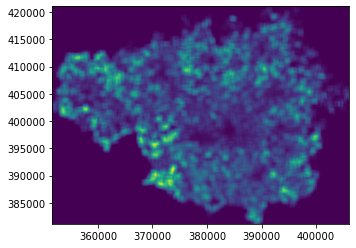

--- 2.0713438987731934 seconds ---


In [120]:
# Grass% layer output at 500m
start_time = time.time()
grass_src_500 = rasterio.open("thesis_project/output/layers/grass_output_500.tif")
show(grass_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [121]:
# output layer metadata
grass_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

## 4.4. Extract raster values at point locations within Greater Manchester Area and store them into a Geodataframe

### 4.4.1. Grass% values at 100m

In [122]:
# check greenspace metrics df
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057,0.780488,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.375649
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596,0.665080,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.100480
2,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539,1.000000,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.203607
3,POINT (390233.154 383013.102),"(390233.154220036, 383013.10249888024)",0.623242,0.916716,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.120871
4,POINT (391596.504 398918.321),"(391596.50390720594, 398918.3206943208)",0.295044,0.403331,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.075581


In [123]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Grass%_100'] = [x[0] for x in grass_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057,0.780488,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.375649,0.158730
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596,0.665080,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.100480,0.038549
2,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539,1.000000,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.203607,0.489796
3,POINT (390233.154 383013.102),"(390233.154220036, 383013.10249888024)",0.623242,0.916716,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.120871,0.056689
4,POINT (391596.504 398918.321),"(391596.50390720594, 398918.3206943208)",0.295044,0.403331,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.075581,0.156463


### 4.4.2. Grass% values at 300m

In [124]:
# check greenspace metrics df
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958,0.355645,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,7.594839e-02
1,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179,0.962298,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.193055e-02
2,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117,0.759169,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.804528e-02
3,POINT (376338.417 418312.798),"(376338.41668971744, 418312.7984642988)",0.431354,0.994809,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.046113e-17
4,POINT (400702.374 407703.870),"(400702.3736142079, 407703.87039896694)",0.602636,0.887576,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.580468e-02


In [125]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Grass%_300'] = [x[0] for x in grass_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958,0.355645,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,7.594839e-02,0.029562
1,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179,0.962298,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.193055e-02,0.381618
2,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117,0.759169,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.804528e-02,0.097823
3,POINT (376338.417 418312.798),"(376338.41668971744, 418312.7984642988)",0.431354,0.994809,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.046113e-17,0.054018
4,POINT (400702.374 407703.870),"(400702.3736142079, 407703.87039896694)",0.602636,0.887576,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.580468e-02,0.135716


### 4.4.3. Grass% values at 500m

In [126]:
# check greenspace metrics df
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912,0.888815,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.079314
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380,0.877726,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104434
2,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857,0.457192,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.147824
3,POINT (385552.048 388856.047),"(385552.0481683999, 388856.047282936)",0.460191,0.652385,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.214477
4,POINT (367806.732 411583.484),"(367806.732180306, 411583.4836614798)",0.641393,0.992871,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.034099


In [127]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Grass%_500'] = [x[0] for x in grass_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912,0.888815,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.079314,0.065092
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380,0.877726,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104434,0.339280
2,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857,0.457192,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.147824,0.125478
3,POINT (385552.048 388856.047),"(385552.0481683999, 388856.047282936)",0.460191,0.652385,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.214477,0.099402
4,POINT (367806.732 411583.484),"(367806.732180306, 411583.4836614798)",0.641393,0.992871,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.034099,0.221743


# 5. Shrubs%

## 5.1. Shrubs No Shrubs input map

In [128]:
# data dir
data_dir = r"thesis_project/data"
fp_shrubs = os.path.join(data_dir, "Shrubs_no_shrubs_10m.TIF")

# open the file
shrubs_input_raster = rasterio.open(fp_shrubs)

# check type of the variable 'raster'
type(shrubs_input_raster)

rasterio.io.DatasetReader

In [129]:
# check metadata for the whole raster dataset
shrubs_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

In [130]:
# read the raster band as separate variable
shrubs_input = shrubs_input_raster.read(1)
#shrubs_input
type(shrubs_input)

numpy.ndarray

In [131]:
# convert array to uint8
shrubs_input = shrubs_input.astype(np.uint8)
shrubs_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

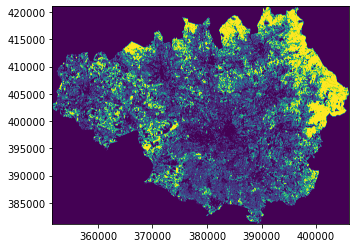

<AxesSubplot:>

In [132]:
# plot input map
show(shrubs_input_raster, 1)

## 5.2. Focal statistics

### 5.2.1. Focal statistics at 100m

In [133]:
# design kernel at a 100m scale
shrubs_filter_100 = np.ones((21, 21))
shrubs_filter_100.shape

(21, 21)

In [134]:
# FFT convolve input map with kernel at 100m (equivalent to average operation)
start_time = time.time()
shrubs_output_100 = fftconvolve(shrubs_input, shrubs_filter_100, mode = "same") / np.sum(shrubs_filter_100) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_100.shape

--- 2.4567008018493652 seconds ---


(3987, 5441)

### 5.2.2. Focal statistics at 300m

In [135]:
# design kernel at a 300m scale
shrubs_filter_300 = np.ones((61, 61))
shrubs_filter_300.shape

(61, 61)

In [136]:
# FFT convolve input map with kernel at 300m (equivalent to average operation)
start_time = time.time()
shrubs_output_300 = fftconvolve(shrubs_input, shrubs_filter_300, mode = "same") / np.sum(shrubs_filter_300) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_300.shape

--- 2.081390857696533 seconds ---


(3987, 5441)

### 5.2.3. Focal statistics at 500m

In [137]:
# design kernel at a 500m scale
shrubs_filter_500 = np.ones((101, 101))
shrubs_filter_500.shape

(101, 101)

In [138]:
# FFT convolve input map with kernel at 500m (equivalent to average operation)
start_time = time.time()
shrubs_output_500 = fftconvolve(shrubs_input, shrubs_filter_500, mode = "same") / np.sum(shrubs_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_500.shape

--- 2.14508318901062 seconds ---


(3987, 5441)

## 5.3. Shrubs% output layer

In [139]:
# checking bounds
shrubs_input_raster.bounds

BoundingBox(left=351662.35, bottom=381166.0433, right=406072.35, top=421036.0433)

### 5.3.1. Shrubs% output layer at 100m

In [140]:
# convert Shrubs% output to raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_100.tif', 'w', driver='GTiff',
                            height = shrubs_output_100.shape[0], width = shrubs_output_100.shape[1],
                            count=1, dtype=str(shrubs_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_100, 1)
new_dataset.close()

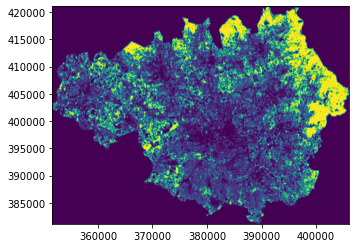

--- 1.3483428955078125 seconds ---


In [153]:
# Shrubs% layer output at 100m
start_time = time.time()
shrubs_src_100 = rasterio.open("thesis_project/output/layers/shrubs_output_100.tif")
show(shrubs_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [154]:
# output layer metadata
shrubs_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 5.3.2. Shrubs% output layer at 300m

In [143]:
# convert Shrubs% output to raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_300.tif', 'w', driver='GTiff',
                            height = shrubs_output_300.shape[0], width = shrubs_output_300.shape[1],
                            count=1, dtype=str(shrubs_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_300, 1)
new_dataset.close()

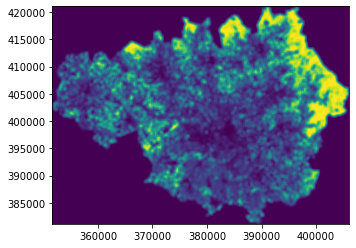

--- 3.0807011127471924 seconds ---


In [146]:
# Shrubs% layer output at 300m
start_time = time.time()
shrubs_src_300 = rasterio.open("thesis_project/output/layers/shrubs_output_300.tif")
show(shrubs_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [147]:
# output layer metadata
shrubs_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 5.3.3. Shrubs% output layer at 500m

In [148]:
# convert Shrubs% output to raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_500.tif', 'w', driver='GTiff',
                            height = shrubs_output_500.shape[0], width = shrubs_output_500.shape[1],
                            count=1, dtype=str(shrubs_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_500, 1)
new_dataset.close()

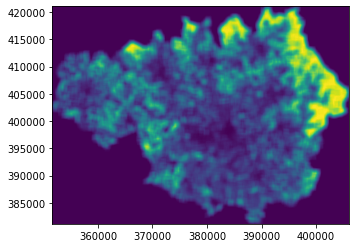

--- 1.491575002670288 seconds ---


In [149]:
# Shrubs% layer output at 500m
start_time = time.time()
shrubs_src_500 = rasterio.open("thesis_project/output/layers/shrubs_output_500.tif")
show(shrubs_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [150]:
# output layer metadata
shrubs_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

## 5.4. Extract raster values at point locations within Greater Manchester Area and store them into a Geodataframe

### 5.4.1. Shrubs% values at 100m

In [151]:
# check greenspace metrics df
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057,0.780488,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.375649,0.158730
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596,0.665080,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.100480,0.038549
2,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539,1.000000,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.203607,0.489796
3,POINT (390233.154 383013.102),"(390233.154220036, 383013.10249888024)",0.623242,0.916716,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.120871,0.056689
4,POINT (391596.504 398918.321),"(391596.50390720594, 398918.3206943208)",0.295044,0.403331,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.075581,0.156463


In [155]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Shrubs%_100'] = [x[0] for x in shrubs_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100,Shrubs%_100
0,POINT (400173.361 405813.506),"(400173.3612805037, 405813.50591000775)",0.462057,0.780488,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.375649,0.158730,0.129252
1,POINT (372621.724 413362.205),"(372621.7240694845, 413362.2046033163)",0.495596,0.665080,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.100480,0.038549,0.482993
2,POINT (383564.442 390537.080),"(383564.44215740403, 390537.0801210402)",0.688539,1.000000,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.203607,0.489796,0.192744
3,POINT (390233.154 383013.102),"(390233.154220036, 383013.10249888024)",0.623242,0.916716,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.120871,0.056689,0.696145
4,POINT (391596.504 398918.321),"(391596.50390720594, 398918.3206943208)",0.295044,0.403331,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.075581,0.156463,0.124717


In [156]:
# check how many points within GM with all metrics
len(gdf_100)

5836

In [157]:
# keep target columns
gdf_100 = gdf_100[['NDVI_100', 'Greenspace%_100', 'Canopy%_100', 'Grass%_100', 'Shrubs%_100', 'geometry']]

# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_100','Greenspace%_100', 'Canopy%_100', 'Grass%_100', 'Shrubs%_100']
gdf_100[cols_to_norm] = gdf_100[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_100.head()

,NDVI_100,Greenspace%_100,Canopy%_100,Grass%_100,Shrubs%_100,geometry
0,0.641659,0.780488,0.787667,0.158730,0.129252,POINT (400173.361 405813.506)
1,0.675657,0.665080,0.210689,0.038549,0.482993,POINT (372621.724 413362.205)
2,0.871239,1.000000,0.426927,0.489796,0.192744,POINT (383564.442 390537.080)
3,0.805049,0.916716,0.253443,0.056689,0.696145,POINT (390233.154 383013.102)
4,0.472362,0.403331,0.158479,0.156463,0.124717,POINT (391596.504 398918.321)


In [158]:
# save geodataframe to geojson
gdf_100.to_file("thesis_project/output/dataframes/greenspace_metrics_100_df.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 5.4.2. Shrubs% values at 300m

In [159]:
# check greenspace metrics df
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958,0.355645,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,7.594839e-02,0.029562
1,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179,0.962298,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.193055e-02,0.381618
2,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117,0.759169,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.804528e-02,0.097823
3,POINT (376338.417 418312.798),"(376338.41668971744, 418312.7984642988)",0.431354,0.994809,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.046113e-17,0.054018
4,POINT (400702.374 407703.870),"(400702.3736142079, 407703.87039896694)",0.602636,0.887576,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.580468e-02,0.135716


In [160]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Shrubs%_300'] = [x[0] for x in shrubs_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300,Shrubs%_300
0,POINT (382286.540 396971.736),"(382286.5399356576, 396971.7357048462)",0.229958,0.355645,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,7.594839e-02,0.029562,0.101854
1,POINT (380292.947 385966.872),"(380292.9471595684, 385966.8717741829)",0.696179,0.962298,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.193055e-02,0.381618,0.274389
2,POINT (388038.733 412187.156),"(388038.7326876332, 412187.1562698502)",0.513117,0.759169,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.804528e-02,0.097823,0.338619
3,POINT (376338.417 418312.798),"(376338.41668971744, 418312.7984642988)",0.431354,0.994809,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.046113e-17,0.054018,0.897877
4,POINT (400702.374 407703.870),"(400702.3736142079, 407703.87039896694)",0.602636,0.887576,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,9.580468e-02,0.135716,0.659231


In [161]:
# check how many points within GM with all metrics
len(gdf_300)

5861

In [162]:
# keep target columns
gdf_300 = gdf_300[['NDVI_300', 'Greenspace%_300', 'Canopy%_300', 'Grass%_300', 'Shrubs%_300', 'geometry']]

# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_300', 'Greenspace%_300', 'Canopy%_300', 'Grass%_300', 'Shrubs%_300']
gdf_300[cols_to_norm] = gdf_300[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_300.head()

,NDVI_300,Greenspace%_300,Canopy%_300,Grass%_300,Shrubs%_300,geometry
0,0.281673,0.336101,1.897265e-01,0.037879,0.101613,POINT (382286.540 396971.736)
1,0.908959,0.961154,2.296515e-01,0.488981,0.274194,POINT (380292.947 385966.872)
2,0.662655,0.751865,2.449267e-01,0.125344,0.338441,POINT (388038.733 412187.156)
3,0.552645,0.994652,1.982036e-16,0.069215,0.897849,POINT (376338.417 418312.798)
4,0.783100,0.884166,2.393294e-01,0.173898,0.659140,POINT (400702.374 407703.870)


In [163]:
# save geodataframe to geojson
gdf_300.to_file("thesis_project/output/dataframes/greenspace_metrics_300_df.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 5.4.3. Shrubs% values at 500m

In [164]:
# check greenspace metrics df
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912,0.888815,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.079314,0.065092
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380,0.877726,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104434,0.339280
2,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857,0.457192,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.147824,0.125478
3,POINT (385552.048 388856.047),"(385552.0481683999, 388856.047282936)",0.460191,0.652385,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.214477,0.099402
4,POINT (367806.732 411583.484),"(367806.732180306, 411583.4836614798)",0.641393,0.992871,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.034099,0.221743


In [165]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Shrubs%_500'] = [x[0] for x in shrubs_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500,Shrubs%_500
0,POINT (362886.156 402352.157),"(362886.1555249354, 402352.15722225094)",0.522912,0.888815,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.079314,0.065092,0.395255
1,POINT (354204.802 403929.521),"(354204.8018881899, 403929.5210523127)",0.463380,0.877726,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104434,0.339280,0.243113
2,POINT (379393.300 410476.219),"(379393.29964144784, 410476.2189101953)",0.371857,0.457192,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.147824,0.125478,0.098814
3,POINT (385552.048 388856.047),"(385552.0481683999, 388856.047282936)",0.460191,0.652385,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.214477,0.099402,0.169787
4,POINT (367806.732 411583.484),"(367806.732180306, 411583.4836614798)",0.641393,0.992871,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.034099,0.221743,0.683855


In [166]:
# check how many points within GM with all metrics
len(gdf_500)

2907

In [167]:
# keep target columns
gdf_500 = gdf_500[['NDVI_500', 'Greenspace%_500', 'Canopy%_500', 'Grass%_500', 'Shrubs%_500', 'geometry']]

# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_500', 'Greenspace%_500', 'Canopy%_500', 'Grass%_500', 'Shrubs%_500']
gdf_500[cols_to_norm] = gdf_500[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_500.head()

,NDVI_500,Greenspace%_500,Canopy%_500,Grass%_500,Shrubs%_500,geometry
0,0.705614,0.883310,0.223834,0.096864,0.394812,POINT (362886.156 402352.157)
1,0.617635,0.871672,0.294723,0.504887,0.241740,POINT (354204.802 403929.521)
2,0.482378,0.430316,0.417175,0.186725,0.096558,POINT (379393.300 410476.219)
3,0.612922,0.635173,0.605278,0.147921,0.167965,POINT (385552.048 388856.047)
4,0.880711,0.992519,0.096232,0.329978,0.685176,POINT (367806.732 411583.484)


In [168]:
# save geodataframe to geojson
gdf_500.to_file("thesis_project/output/dataframes/greenspace_metrics_500_df.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
